# CNN-LSTM Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import glob
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## Device Setup

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

os.makedirs('models', exist_ok=True)
os.makedirs('graphs', exist_ok=True)

Using device: cuda


## Load Data

In [3]:
input_files = sorted(glob.glob('data/train/input_*.csv'))
output_files = sorted(glob.glob('data/train/output_*.csv'))

input_dfs = [pd.read_csv(f) for f in input_files]
output_dfs = [pd.read_csv(f) for f in output_files]

input_df = pd.concat(input_dfs, ignore_index=True)
output_df = pd.concat(output_dfs, ignore_index=True)

print(f'Loaded {len(input_files)} weeks')
print(f'Input: {input_df.shape}, Output: {output_df.shape}')

Loaded 18 weeks
Input: (4880579, 23), Output: (562936, 6)


## Feature Engineering

In [4]:
input_df['player_height_inches'] = input_df['player_height'].str.split('-').apply(
    lambda x: int(x[0])*12 + int(x[1]) if isinstance(x, list) and len(x)==2 else np.nan
)

input_df['player_age'] = 2023 - pd.to_datetime(input_df['player_birth_date']).dt.year

encoders = {}
for col in ['player_position', 'player_side', 'player_role', 'play_direction']:
    encoders[col] = LabelEncoder()
    input_df[f'{col}_enc'] = encoders[col].fit_transform(input_df[col].fillna('Unknown'))

print('Features engineered')

Features engineered


## Merge and Prepare Features

In [5]:
df = input_df.merge(output_df, on=['game_id', 'play_id', 'nfl_id'], suffixes=('', '_target'))

features = [
    'x', 'y', 's', 'a', 'dir', 'o',
    'ball_land_x', 'ball_land_y',
    'absolute_yardline_number',
    'player_height_inches', 'player_weight', 'player_age',
    'player_position_enc', 'player_side_enc', 'player_role_enc', 'play_direction_enc',
    'frame_id', 'num_frames_output',
    'player_to_predict'
]

X = df[features].fillna(0).astype(float)
y = df[['x_target', 'y_target']]

print(f'Features: {X.shape[1]}')
print(f'Samples: {len(X):,}')

Features: 19
Samples: 16,534,398


## Split and Scale

In [6]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(2).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).unsqueeze(2).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(2).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

print(f'Train: {len(X_train):,}, Val: {len(X_val):,}, Test: {len(X_test):,}')

Train: 11,574,078, Val: 1,653,440, Test: 3,306,880


## DataLoaders

In [7]:
batch_size = 256

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

print(f'Batch size: {batch_size}')

Batch size: 256


## Define Model

In [8]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(19, 32, kernel_size=1)
        self.lstm = nn.LSTM(32, 64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 2)
    
    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

model = CNNLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Parameters: 59,138


## Train Model

In [9]:
epochs = 100
patience = 15
best_val_loss = float('inf')
patience_counter = 0

history = {'train_loss': [], 'val_loss': []}

start = time.time()
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'models/cnn_lstm.pth')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')
    
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break
 
train_time = time.time() - start
print(f'Training time: {train_time:.2f}s')

Epoch 10: Train Loss=11.7961, Val Loss=11.7376
Epoch 20: Train Loss=11.2204, Val Loss=11.2174
Epoch 30: Train Loss=10.9949, Val Loss=11.0009
Epoch 40: Train Loss=10.8821, Val Loss=10.9136
Epoch 50: Train Loss=10.8052, Val Loss=10.8550
Epoch 60: Train Loss=10.7513, Val Loss=10.7439
Epoch 70: Train Loss=10.7069, Val Loss=10.7234
Epoch 80: Train Loss=10.4717, Val Loss=10.4998
Epoch 90: Train Loss=10.4494, Val Loss=10.4776
Epoch 100: Train Loss=10.4297, Val Loss=10.4679
Training time: 15377.52s


## Load Best Model and Predict

In [13]:
model.load_state_dict(torch.load('models/cnn_lstm.pth'))
model.eval()

y_train_pred = []
with torch.no_grad():
    for X_batch, _ in train_loader:
        preds = model(X_batch).cpu().numpy()
        y_train_pred.append(preds)
y_train_pred = np.vstack(y_train_pred)

y_test_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        preds = model(X_batch).cpu().numpy()
        y_test_pred.append(preds)
y_test_pred = np.vstack(y_test_pred)

print('Predictions generated')

Predictions generated


## Metrics

In [14]:
train_rmse = np.sqrt(mean_squared_error(y_train.values, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test.values, y_test_pred))
train_r2 = r2_score(y_train.values, y_train_pred)
test_r2 = r2_score(y_test.values, y_test_pred)

errors = np.sqrt(np.sum((y_test.values - y_test_pred)**2, axis=1))
mean_error = errors.mean()

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE:  {test_rmse:.4f}')
print(f'Train R²:   {train_r2:.4f}')
print(f'Test R²:    {test_r2:.4f}')
print(f'Mean Error: {mean_error:.4f} yards')

Train RMSE: 28.4672
Test RMSE:  3.2287
Train R²:   -0.9669
Test R²:    0.9646
Mean Error: 3.7544 yards


## Training History

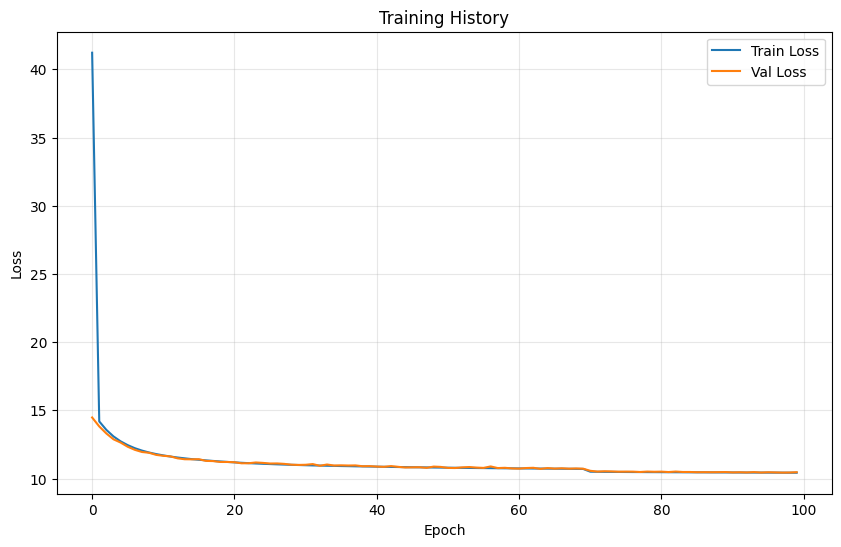

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('graphs/cnn_lstm_training_history.png', dpi=300)
plt.show()

## Predictions

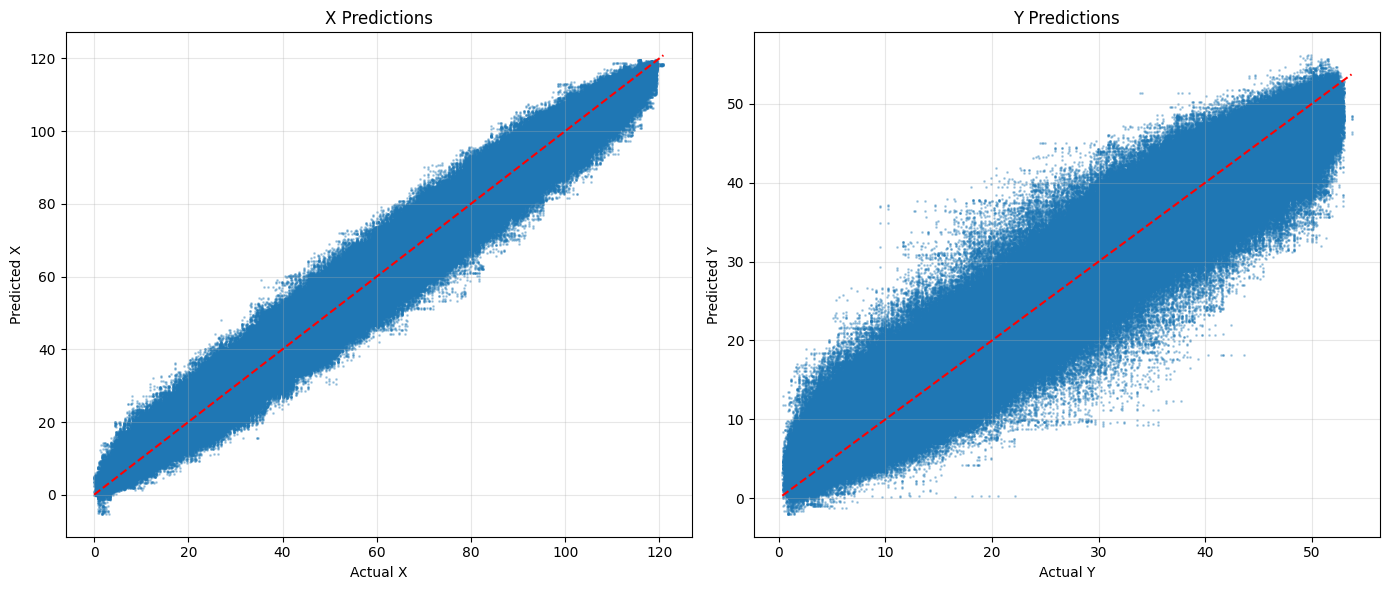

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test.iloc[:, 0], y_test_pred[:, 0], alpha=0.3, s=1)
axes[0].plot([y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 
             [y_test.iloc[:, 0].min(), y_test.iloc[:, 0].max()], 'r--')
axes[0].set_xlabel('Actual X')
axes[0].set_ylabel('Predicted X')
axes[0].set_title('X Predictions')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test.iloc[:, 1], y_test_pred[:, 1], alpha=0.3, s=1)
axes[1].plot([y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 
             [y_test.iloc[:, 1].min(), y_test.iloc[:, 1].max()], 'r--')
axes[1].set_xlabel('Actual Y')
axes[1].set_ylabel('Predicted Y')
axes[1].set_title('Y Predictions')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('graphs/cnn_lstm_predictions.png', dpi=300)
plt.show()

## Error Distribution

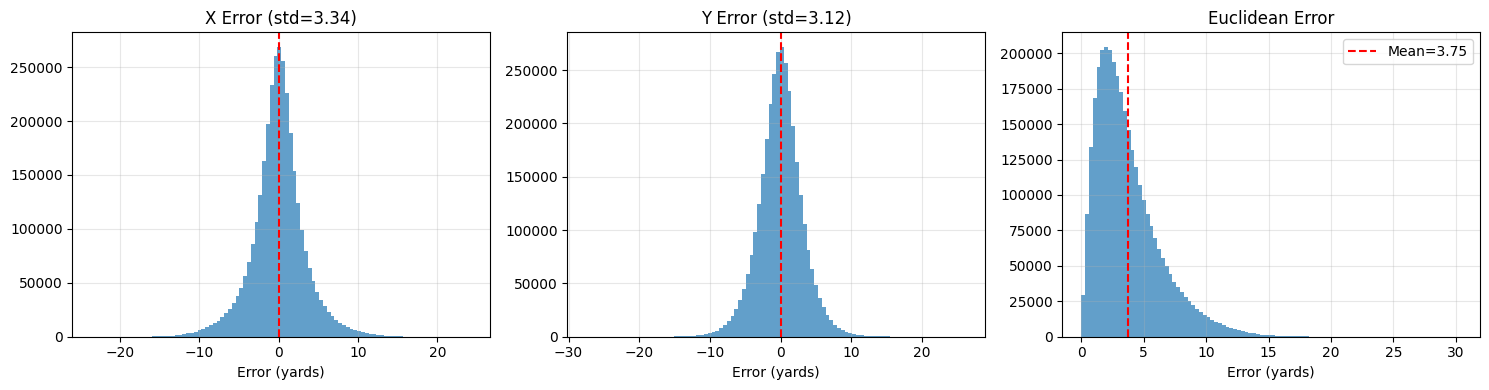

In [17]:
errors_x = y_test.iloc[:, 0].values - y_test_pred[:, 0]
errors_y = y_test.iloc[:, 1].values - y_test_pred[:, 1]
errors_euclidean = np.sqrt(errors_x**2 + errors_y**2)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(errors_x, bins=100, alpha=0.7)
axes[0].axvline(0, color='r', linestyle='--')
axes[0].set_xlabel('Error (yards)')
axes[0].set_title(f'X Error (std={np.std(errors_x):.2f})')
axes[0].grid(alpha=0.3)

axes[1].hist(errors_y, bins=100, alpha=0.7)
axes[1].axvline(0, color='r', linestyle='--')
axes[1].set_xlabel('Error (yards)')
axes[1].set_title(f'Y Error (std={np.std(errors_y):.2f})')
axes[1].grid(alpha=0.3)

axes[2].hist(errors_euclidean, bins=100, alpha=0.7)
axes[2].axvline(mean_error, color='r', linestyle='--', label=f'Mean={mean_error:.2f}')
axes[2].set_xlabel('Error (yards)')
axes[2].set_title('Euclidean Error')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('graphs/cnn_lstm_error_distribution.png', dpi=300)
plt.show()